<a href="https://colab.research.google.com/github/huoxiaoyao/Machine_Perception_exercises/blob/master/2a_eye_gaze_for_students_with_blanks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build Your Own MLP - Eye Gaze Estimation

In the first part of the course you have implemented your own neural network using nothing but python, numpy and some brain power. In this additional part we will:

1. Refactor and generalize the code
2. Apply the learned concepts to the task of eye-gaze estimation.

Eye-gaze information has many applications in Human-Computer Interaction such as improving user experience in everyday tasks, such as [reading](http://gbuscher.com/publications/BuscherBiedert10_readingRegions.pdf), or facilitate [gaze-based interaction](https://perceptual.mpi-inf.mpg.de/files/2014/07/majaranta14_apc.pdf). Eye-gaze also plays a crucial role in assisting users with motor-disabilities and can even be used to infer cognitive state such as cognitive load. Recently, deep-learning based gaze estimation was used for [unsupervised eye contact detection](https://perceptual.mpi-inf.mpg.de/files/2017/05/zhang17_uist.pdf) in everyday scenarios.

The eye gaze data we'll be using is based on [UnityEyes](https://www.cl.cam.ac.uk/research/rainbow/projects/unityeyes/), a synthetic eyes dataset. Note that this is a clean and simple dataset as far as eye gaze estimation goes. The real-world task (real images, uncontrolled environmental conditions) is much more challenging and comprehensively solving this is an active area of research that would go beyond the scope of this notebook.

In [1]:
!if [ ! -f eye_data.h5 ]; then wget -nv https://github.com/jtj21/ComputationalInteraction18/blob/master/Otmar/data/eye_data.h5?raw=true -O eye_data.h5; fi
  
import h5py
from IPython import display
import matplotlib.pyplot as plt
import numpy as np

2020-08-20 11:40:13 URL:https://raw.githubusercontent.com/jtj21/ComputationalInteraction18/master/Otmar/data/eye_data.h5 [37401200/37401200] -> "eye_data.h5" [1]


With the necessary data and libraries imported, let's create split our dataset into training, validation and test sets.

In [11]:
# Load in our data
with h5py.File('eye_data.h5', 'r') as h5f:

  train_x = h5f['train/x_small'][:]
  train_y = h5f['train/y'][:]

  validation_x = h5f['validation/x_small'][:]
  validation_y = h5f['validation/y'][:]

  test_x = h5f['test/x_small'][:]
  test_y = h5f['test/y'][:]

# Task definition and metric

We will apply the concepts we previously learned to build a simple neural network for directly regressing the gaze direction from single eye-images. 
For this purpose we will represent gaze direction by pitch and yaw in radians. 

Since pitch and yaw angles are difficult to interpret we will also define a more intuitive *angular* error metric based on [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity#Angular_distance_and_similarity). Angular distance in this case, is a single scalar value which would describe how many degrees the eyeball would need to turn to face match the estimated gaze direction.

In addition we will define some helper functions to compute the metrics and a method to visualize our results.

In [12]:
def angular_error(X, y):
    """Calculate angular error (via cosine similarity)."""

    def pitchyaw_to_vector(pitchyaws):
        """Convert given pitch and yaw angles to unit gaze vectors."""
        n = pitchyaws.shape[0]
        sin = np.sin(pitchyaws)
        cos = np.cos(pitchyaws)
        out = np.empty((n, 3))
        out[:, 0] = np.multiply(cos[:, 0], sin[:, 1])
        out[:, 1] = sin[:, 0]
        out[:, 2] = np.multiply(cos[:, 0], cos[:, 1])
        return out

    a = pitchyaw_to_vector(y) 
    b = pitchyaw_to_vector(X)

    ab = np.sum(np.multiply(a, b), axis=1)
    a_norm = np.linalg.norm(a, axis=1)
    b_norm = np.linalg.norm(b, axis=1)

    # Avoid zero-values (to avoid NaNs)
    a_norm = np.clip(a_norm, a_min=1e-7, a_max=None)
    b_norm = np.clip(b_norm, a_min=1e-7, a_max=None)

    similarity = np.divide(ab, np.multiply(a_norm, b_norm))

    return np.arccos(similarity) * (180.0 / np.pi)


def predict_and_calculate_mean_error(nn, x, y):
    """Calculate mean error of neural network predictions on given data."""
    n, _, _ = x.shape
    predictions = nn.predict(x.reshape(n, -1)).reshape(-1, 2)
    labels = y.reshape(-1, 2)
    errors = angular_error(predictions, labels)
    return np.mean(errors)


def predict_and_visualize(nn, x, y):
    """Visualize errors of neural network on given data."""
    %matplotlib inline
    nr, nc = 1, 12
    n = nr * nc
    fig = plt.figure(figsize=(12, 2.))
    predictions = nn.predict(x[:n, :].reshape(n, -1))
    for i, (image, label, prediction) in enumerate(zip(x[:n], y[:n], predictions)):
        plt.subplot(nr, nc, i + 1)
        plt.imshow(image, cmap='gray')
        error = angular_error(prediction.reshape(1, 2), label.reshape(1, 2))
        plt.title('%.1f' % error, color='g' if error < 7.0 else 'r')
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    plt.tight_layout(pad=0.0)
    plt.show()

# Network structure

We can now begin defining our neural network, a simple multi-layer perceptron (MLP) with just a single hidden layer. This time we'll refactor the code a little to make it more configurable than in the first part of the tutorial.


## Activation function
First, we define a new activation function known as **Rectified Linear Unit** or **ReLU** and its derivative.



In [13]:
def ReLU(x):
    """Computes the Rectified Linear Unit function."""
    return x * (x > 0)

def ReLU_(x):
    """Computes the derivative of the ReLU function."""
    return (x > 0).astype(np.float32)

The ReLU and its derivative look like this:

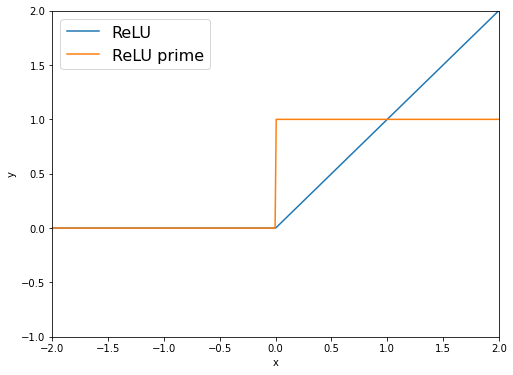

In [14]:
x = np.linspace(-2., 2., num=400)
relu = ReLU(x)
relu_prime = ReLU_(relu)

plt.figure(figsize=(8, 6))
plt.plot(x, relu, label="ReLU")
plt.plot(x, relu_prime, label="ReLU prime")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim([-2, 2])
plt.ylim([-1, 2])
plt.legend(prop={'size' : 16})
plt.show()

Note how the ReLU activation function only passes through positive input values, rejecting all negative input values. This simple *non-linear* function can be stacked to create highly complex non-linear models. In addition, the very definite nature of its decision results in a so-called *sparsification* of a neural network, yielding quicker training times. That is, neurons are quickly selected to be "killed off", leaving just useful neurons active. See [this page](https://cs231n.github.io/neural-networks-1/) for a concise introduction to various activation functions and their pros and cons.

We now define our error metric, the mean-squared error as the following:

$$MSE\left(y,\hat{y}\right) = \frac{1}{n} \sum_{i=0}^n \left(y_i - \hat{y}_i\right)^2$$

where there are $n$ output values in the ground-truth output $y$ and predicted output $\hat y$.

In [15]:
def MSE(Y, YH):
    """Compute elementwise mean square error between two matrices."""
    return np.mean(np.square(Y - YH))

We implement our neural network as a class, `NNRegressor`.

In [16]:
class NNRegressor:

    def __init__(self, n_outputs, n_features, n_hidden_units=30,
                 l2_reg=0.0, epochs=500, learning_rate=0.01,
                 batch_size=10, random_seed=None):

        if random_seed:
            np.random.seed(random_seed)
        self.n_outputs = n_outputs
        self.n_features = n_features
        self.n_hidden_units = n_hidden_units
        self.w1, self.w2 = self._init_weights()
        self.l2_reg = l2_reg
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.batch_size = batch_size

    def _init_weights(self):
        # Truncated normal for weights initialization
        w1 = np.random.normal(0.0, 0.01, 
                              size=self.n_hidden_units * (self.n_features + 1))
        w1 = np.clip(w1, -0.01, 0.01)
        w1 = w1.reshape(self.n_hidden_units, self.n_features + 1)
        w1[:, 0] = 1e-5  # Constant bias initialization
        w2 = np.random.normal(0.0, 0.01, 
                              size=self.n_outputs * (self.n_hidden_units + 1))
        w2 = np.clip(w2, -0.01, 0.01)
        w2 = w2.reshape(self.n_outputs, self.n_hidden_units + 1)
        w2[:, 0] = 1e-5  # Constant bias initialization
        return w1, w2

    def _add_bias_unit(self, X, how='column'):
        if how == 'column':
            X_new = np.ones((X.shape[0], X.shape[1] + 1))
            X_new[:, 1:] = X
        elif how == 'row':
            X_new = np.ones((X.shape[0] + 1, X.shape[1]))
            X_new[1:, :] = X
        return X_new

    def _error(self, y, output):
        return MSE(y, output)

    def _backprop_step(self, X, y):
        net_hidden, act_hidden, net_out = self._forward(X)
        grad1, grad2 = self._backward(X, net_hidden, act_hidden, net_out, y)
        
        # regularize
        grad1[:, 1:] += 2 * self.l2_reg * self.w1[:, 1:]
        grad2[:, 1:] += 2 * self.l2_reg * self.w2[:, 1:]
        
        error = self._error(y, net_out)
        return error, grad1, grad2

    def predict(self, X):
        net_hidden, act_hidden, net_out = self._forward(X)
        return net_out

    def fit(self, X_train, y_train, X_test, y_test):
        training_errors = []
        testing_errors = []

        self.error_ = []
        for i in range(self.epochs):
            n_batches = int(X_train.shape[0] / self.batch_size)
            X_mb = np.array_split(X_train, n_batches)
            y_mb = np.array_split(y_train, n_batches)
            
            epoch_errors = []

            for Xi, yi in zip(X_mb, y_mb):
                batch_size = Xi.shape[0]
                
                # update weights
                error, grad1, grad2 = self._backprop_step(Xi.reshape(batch_size, -1), yi)
                epoch_errors.append(error)
                self.w1 -= (self.learning_rate * grad1)
                self.w2 -= (self.learning_rate * grad2)
            mean_epoch_errors = np.mean(epoch_errors)
            self.error_.append(mean_epoch_errors)

            # Evaluate errors and visualize progress
            if i % 5 == 0:
                batch_train_error = predict_and_calculate_mean_error(self, Xi, yi)
                training_errors.append([i + 1, batch_train_error])
                if i % 10 == 0:
                    mean_test_error = predict_and_calculate_mean_error(self, X_test, y_test)
                    testing_errors.append([i + 1, mean_test_error])
                    print('Epoch %d> mean test error: %f degrees' % (i + 1, mean_test_error))
                    predict_and_visualize(self, X_test, y_test)

        # Now plot a graph of error progression
        training_errors = np.asarray(training_errors)
        testing_errors = np.asarray(testing_errors)
        plt.plot(training_errors[:, 0], training_errors[:, 1], 'g-*', label='train')
        plt.plot(testing_errors[:, 0], testing_errors[:, 1], 'b-*', label='test')
        plt.legend()
        plt.xlabel('Epochs')
        plt.ylabel('Angular Gaze Error')

        return self

The definition of this class is currently missing the `NNRegressor._forward` and `NNRegressor._backward` method definitions.

Please fill this in below, being mindful of the dimensions involved. 
Note that biases can be pre-pended to the weights. Here is a pictorial representation of this idea:

![NN with pre-pended bias node](https://i.imgur.com/u7RsiQR.png)

In [20]:
def nn_forward_pass(self, X):
    """Perform a forward pass of input data through this neural network.
    
    Note: The output of every step of this forward pass must be cached to be 
          used for the backward-pass. The backward-pass updates the neural 
          network weight and bias parameters.
    
    Params:
        X: input data of shape (N x F)

    Neural Network Weights:
        self.w1: weight parameters of shape (H x F+1)
        self.w2: weight parameters of shape (O x H+1)
        
    Legend:
        N: Number of input data entries
        F: Number of features
        H: Number of neurons in hidden layer
        O: Number of output values
    """
    ## First step: ReLU(X * W1)
    # Adjust input data to be of shape (N x F+1)
    net_input_padded = self._add_bias_unit(X, how='column')
    
    # Calculate hidden layer output of shape (N x H)
    net_hidden = np.matmul(net_input_padded, self.w1.T)
    
    # Calculate hidden layer activations of shape (N x H)
    act_hidden = ReLU(net_hidden)
    
    ## Second step: X * W2
    # Adjust activations to be of shape (N x H+1)
    act_hidden_padded = self._add_bias_unit(act_hidden, how='column')
    
    # Calculate neural network output of shape (N x O)
    net_out = np.matmul(act_hidden_padded, self.w2.T)
    
    return net_hidden, act_hidden, net_out

NNRegressor._forward = nn_forward_pass

We can now feed our inputs through the neural network to calculate the output.

In order to be able to update our weight and bias matrices, we must now calculate gradients with respect to the output predictions (`net_out`) and ground-truth labels (`y`).

In [21]:
def nn_gradient_calculations(self, net_input, net_hidden, act_hidden, net_out, y):
    """Calculate gradients for a backward pass through this neural network.
    
    Params:
        net_input: input data of shape (N x F)
        net_hidden: output of hidden layer (N x H)
        act_hidden: activations of hidden layer (N x H)
        net_out: output of neural network (N x O)
        y: ground-truth labels (N x O)

    Neural Network Weights:
        self.w1: weight parameters of shape (H x F+1)
        self.w2: weight parameters of shape (O x H+1)
        
    Legend:
        N: Number of input data entries
        F: Number of features
        H: Number of neurons in hidden layer
        O: Number of output values
    """
    
    # Calculate error residual (N x O)
    de_do = 2 * (net_out - y) / y.shape[1]
    
    #---#
    
    # Calculate derivative of output w.r.t w2 (N x H+1)
    # this is bs: shouldn't we work with the padded existing value (real bias)?
    # Or shouldn't the bias learn over multiple rounds?
    do_dw2 = self._add_bias_unit(act_hidden, how='column')
    
    # Calculate gradient w.r.t self.w2 (O x H+1)
    de_dw2 = np.matmul(de_do.T, do_dw2)
    
    #---#
    
    # Calculate derivative of output w.r.t hidden layer activations (O x H+1)
    do_da = self.w2
    
    # Calculate derivative of hidden layer activations w.r.t hidden layer output (N x H+1)
    da_dh = ReLU_(self._add_bias_unit(net_hidden, how='column'))
    
    # Calculate derivative of hidden layer output w.r.t w1 (N x F+1)
    dh_dw1 = self._add_bias_unit(net_input, how='column')
    
    # Calculate gradient w.r.t self.w1 (H x F+1)
    #shouldn't this be (N x F+1) and the last mult the other way around???
    de_dw1 = np.matmul((np.matmul(de_do, do_da) * da_dh).T, dh_dw1)[1:, :]

    return de_dw1, de_dw2

NNRegressor._backward = nn_gradient_calculations

# Training and prediction

Let's test if our implementation works.

With the following code, you can create a neural network and train it using our eye-gaze data. While training, you will be able to see visually how well the optimization is proceeding via inspecting a select number of eye-images and their associated training error. After the training stops, you will see a graph summary of how your training and test errors progressed.

Look out for the following phenomena:

* **Overfitting**. When the network learns too specific patterns of the training data, it becomes less capable of generalizing its predictive capabilities to unseen test data. Or in other words, the training error reduces noticably without a noticable decrease in the test error.
* **Underfitting**. When the network is learning so little that it performs as well as it does on seen data (training) and unseen data (test).

In addition, pay attention to the speed of the training process. Which parameters should be tweaked to allow for quicker training without overfitting?

Epoch 1> mean test error: 22.957699 degrees


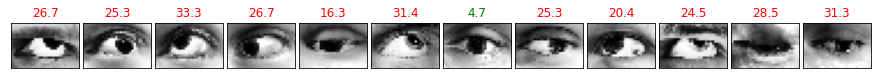

Epoch 11> mean test error: 8.681666 degrees


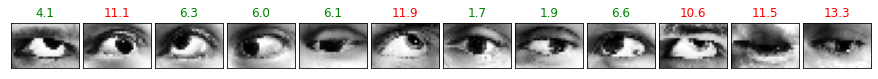

Epoch 21> mean test error: 7.496698 degrees


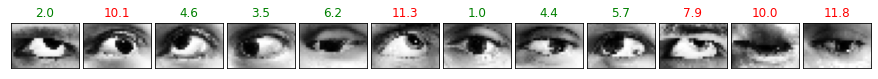

Epoch 31> mean test error: 6.985911 degrees


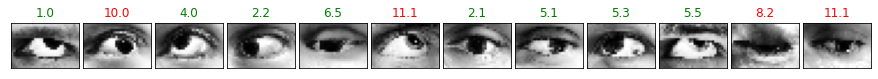

Epoch 41> mean test error: 6.686156 degrees


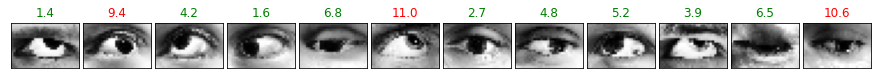

Epoch 51> mean test error: 6.478671 degrees


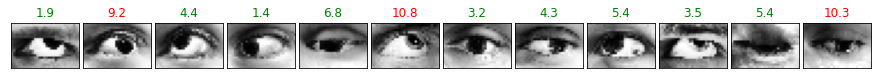

Epoch 61> mean test error: 6.330191 degrees


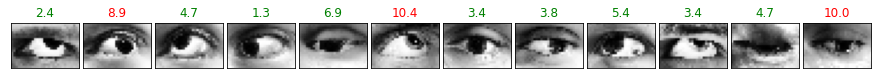

Epoch 71> mean test error: 6.213594 degrees


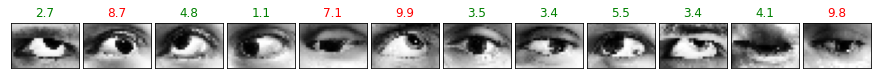

Epoch 81> mean test error: 6.120415 degrees


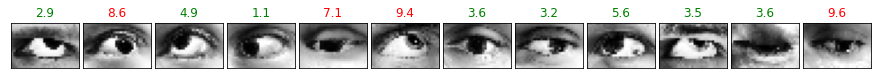

Epoch 91> mean test error: 6.042366 degrees


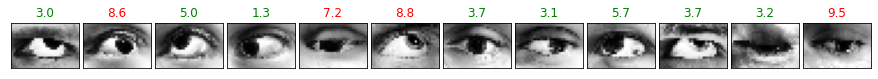

Epoch 101> mean test error: 5.982255 degrees


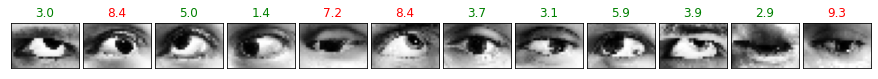

Epoch 111> mean test error: 5.928808 degrees


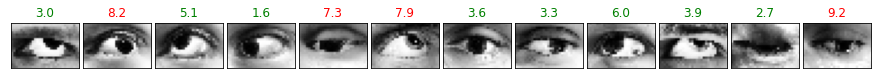

Epoch 121> mean test error: 5.881166 degrees


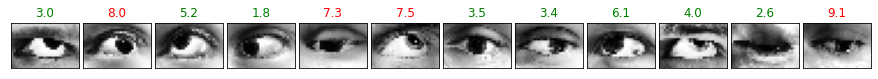

Epoch 131> mean test error: 5.841793 degrees


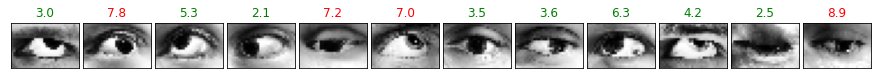

Epoch 141> mean test error: 5.805092 degrees


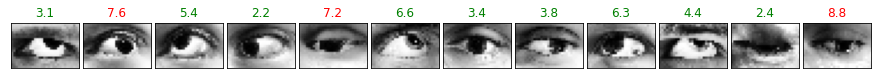

Epoch 151> mean test error: 5.774974 degrees


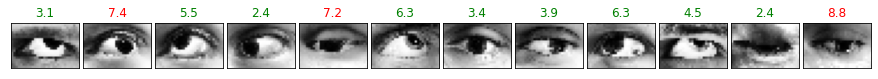

Epoch 161> mean test error: 5.750596 degrees


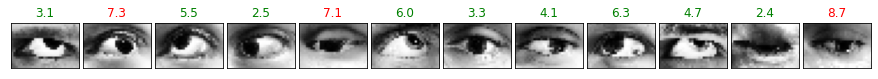

Epoch 171> mean test error: 5.729329 degrees


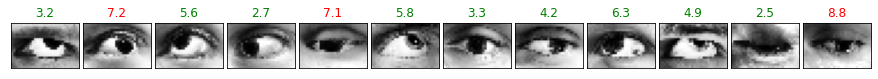

Epoch 181> mean test error: 5.711848 degrees


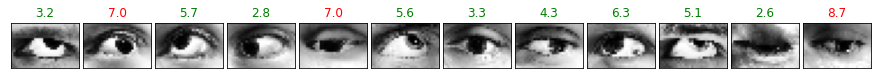

Epoch 191> mean test error: 5.694650 degrees


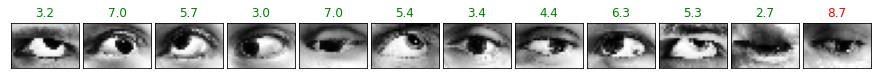

Epoch 201> mean test error: 5.683385 degrees


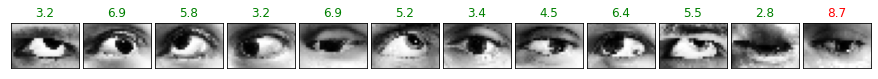

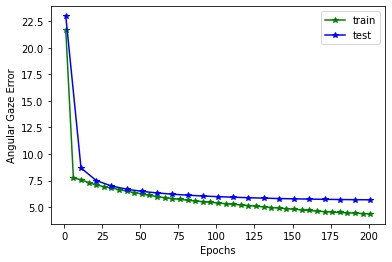

In [22]:
# A neural network should be trained until the training and test
# errors plateau, that is, they do not improve any more.
epochs = 201

# Having more neurons in a network allows for more complex 
# mappings to be learned between input data and expected outputs.
# However, defining the function to be too complex can lead to 
# overfitting, that is, any function can be learned to memorize
# training data.
n_hidden_units = 64

# Lower batch sizes can cause noisy training error progression,
# but sometimes lead to better generalization (less overfitting
# to training data)
batch_size = 16

# A higher learning rate makes training faster, but can cause
# overfitting
learning_rate = 0.0005

# Increase to reduce over-fitting effects
l2_regularization_coefficient = 0.0001

N_FEATURES = len(train_x[0, :].flatten())
N_OUTPUTS = train_y.shape[1]

nn = NNRegressor(n_outputs=N_OUTPUTS,
                 n_features=N_FEATURES,
                 n_hidden_units=n_hidden_units,
                 l2_reg=l2_regularization_coefficient,
                 epochs=epochs,
                 learning_rate=learning_rate,
                 batch_size=batch_size,
                 random_seed=42)

nn.fit(train_x, train_y, test_x, test_y);

# Appendix

What we are performing here is called *mini-batch gradient descent*. That is, we take a small sample of data points from our *training data*, and calculate our gradient update. Note that in the XOR exercise we performed *batch gradient descent* based on the full training dataset of 4 entries.

What this means is that our method adds an additional hyperparameter to the training procedure in terms of how well or how quickly we can have our neural network learn. The hyperparameter is namely the *batch size*. If batch size is high, each gradient updates takes more computation but the gradient descent becomes more stable (and slow). If the batch size is too low, each gradient update may be so noisy that it becomes difficult to reach the optimum.

When learning data-driven models, we often split our available data into training, validation and testing sub-sets. That is, we train our model on the training data, validate the performance of the model being trained occasionally, and finally produce a test error which characterizes the generalization capability of the model. Low batch sizes have shown to improve generalization, so finding a "sweet spot" in terms of batch size can be important in some cases.

![](https://i.imgur.com/6spauos.png)

A more core consideration for the training of neural networks is learning rate. The graphic below should characterize the three scenarios quite well. Note that this refers to the training loss progression, not the test loss progression.

![](https://i.imgur.com/QaikS9E.png)

Adjusting the learning rate based on training loss progression alone is insufficient as you can see in the following *over-fitting* phenomenon. That is, our model performs increasingly better on training data, but cannot transfer or *generalize* its knowledge to unseen validation or test data. When this occurs, one should (among other actions) consider lowering both learning rate and batch size.

![](https://i.imgur.com/QtMc8us.png)